In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from glob import glob

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sbibm
from sbi.analysis as analysis
from sbibm.utils.io import get_tensor_from_csv

In [83]:
def get_training_samples_id(path: str):
    directory_name = path.split("/")[-1]
    training_samples_id = directory_name.split("_")[-1]
    return int(training_samples_id)


def get_relative_path(reported_path: str, prefix: str = "multirun/", prefix_to_remove: str = "/home/ben/sci/cnre/benchmarking/multirun/"):
    return prefix + reported_path[len(prefix_to_remove):]

def get_validation_losses(root):
    root = Path(root)
    return get_tensor_from_csv(root / "validation_losses.csv.bz2")

def get_posterior_samples(root: str):
    root = Path(root)
    return get_tensor_from_csv(root / "posterior_samples.csv.bz2")

def plot_posterior(samples, true_theta=None, name=None, limits=None):
    points = None if true_theta is None else true_theta.cpu().numpy()
    fig, _ = analysis.pairplot(
        samples.cpu().numpy(), 
        figsize=(6,6), 
        points=points,
        title=name,
        limits=limits,
    )

    
def get_reference_samples_from_row(row):
    task_name = row["task"]
    num_observation = row["num_observation"]
    task = sbibm.get_task(task_name)
    return task.get_reference_posterior_samples(num_observation)

def get_true_theta_from_row(row):
    task_name = row["task"]
    num_observation = row["num_observation"]
    task = sbibm.get_task(task_name)
    return task.get_true_parameters(num_observation)

In [30]:
# df = pd.read_csv("metrics.csv", index_col=0)
df = pd.read_csv("metrics-0401.csv", index_col=0)
df = pd.read_csv("metrics-0402.csv", index_col=0)

files = [
    "metrics-0401.csv", 
    "metrics-0402.csv",
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)
df["training_samples_id"] = df["training_samples_root"].map(get_training_samples_id)
df.head()

,task,num_simulations,num_observation,seed,max_num_epochs,algorithm,num_atoms,gamma,training_samples_root,C2ST,C2ST_Z,MMD,MMD_Z,MEDDIST,NLTP,RT,num_simulations_simulator,path,folder,training_samples_id
0,two_moons,100000,3,2663618357,300,CNRE,2,0.10,training-data/02,0.54240,0.6984,0.000553,0.000553,0.089898,NaN,20.742698,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,103,2
1,two_moons,100000,5,3563846039,300,CNRE,75,0.10,training-data/01,0.65625,0.6540,0.005574,0.005574,0.093124,NaN,65.047803,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,242,1
2,two_moons,100000,5,2431131409,300,CNRE,50,1.00,training-data/02,0.55100,0.5510,0.008917,0.008917,0.093000,NaN,49.518542,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,235,2
3,slcp,100000,6,1712894792,300,CNRE,25,0.10,training-data/02,0.92135,0.9216,0.186850,0.230155,19.444147,NaN,55.594006,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,773,2
4,slcp,100000,3,1856857265,300,CNRE,25,0.01,training-data/02,0.74610,0.7595,0.003001,0.012471,26.922518,NaN,72.258887,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,621,2


In [5]:
df["task"].unique()

array(['two_moons', 'slcp', 'gaussian_mixture'], dtype=object)

In [6]:
df["gamma"].unique()

array([1.e-01, 1.e+00, 1.e-02, 1.e+01, 1.e+02,    nan])

## cnre

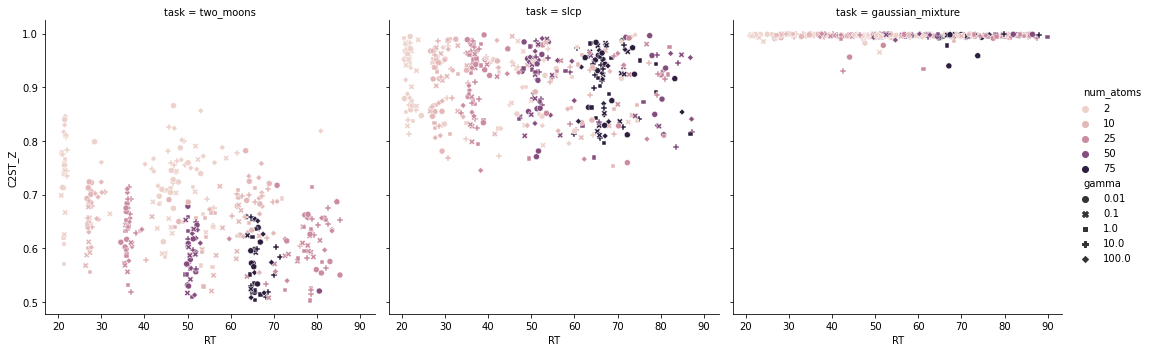

In [18]:
# Run times
dfcnre = df[df["algorithm"] == "CNRE"]
sns.relplot(
    data=dfcnre, 
    x="RT",
    y="C2ST_Z",
    style="gamma", 
    # hue="algorithm", 
    hue="num_atoms",
    col="task",
    # kind="line",
)

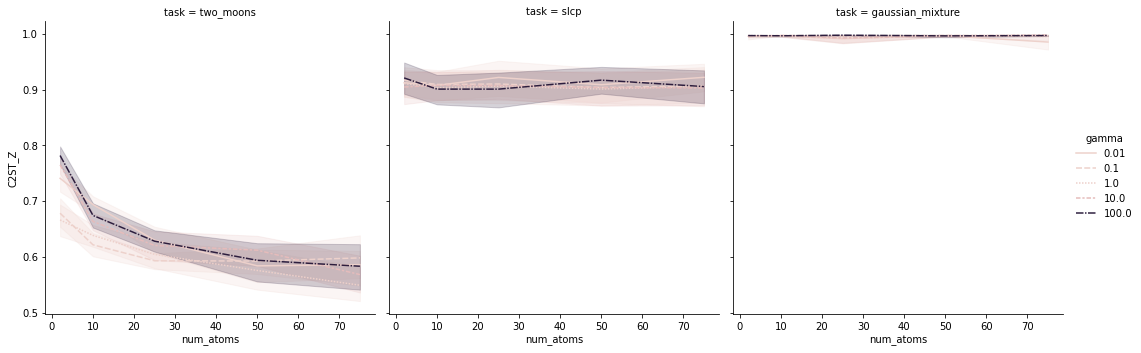

In [7]:
# quality
dfcnre = df[df["algorithm"] == "CNRE"]
sns.relplot(
    data=dfcnre, 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    # hue="algorithm", 
    hue="gamma",
    col="task",
    kind="line",
)

## num atoms

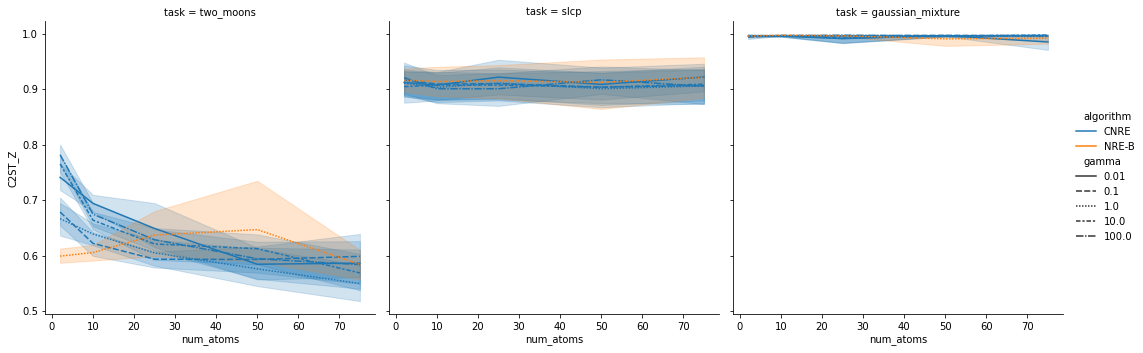

In [8]:
sns.relplot(
    data=df.fillna(1.0), 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    hue="algorithm", 
    col="task",
    kind="line",
    # row="task",
)

## specific

0.6984


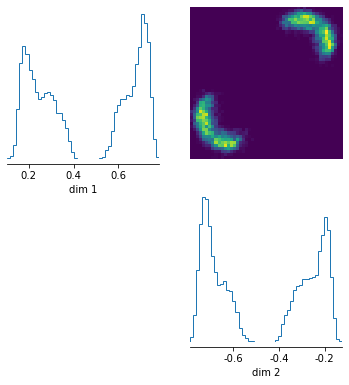

In [64]:
print(df.loc[0, "C2ST_Z"])
p = get_relative_path(df.loc[0, "path"], "saverun/two_moons-slcp/", "/home/ben/sci/cnre/benchmarking/multirun/2022-04-01/")
p = get_posterior_samples(p)
plot_posterior(p)

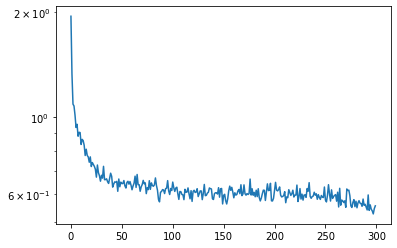

In [94]:
dfrel = df[
    (df["num_atoms"] == 75) &
    (df["task"] != "gaussian_mixture")
]
idx = 4
row = dfrel.iloc[idx]
p = get_relative_path(row["path"], "saverun/two_moons-slcp/", "/home/ben/sci/cnre/benchmarking/multirun/2022-04-01/")

plt.semilogy(get_validation_losses(p).numpy())

0.99695
/home/ben/sci/cnre/benchmarking/multirun/2022-04-02/18-02-23/103


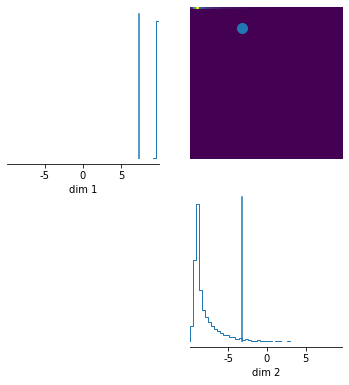

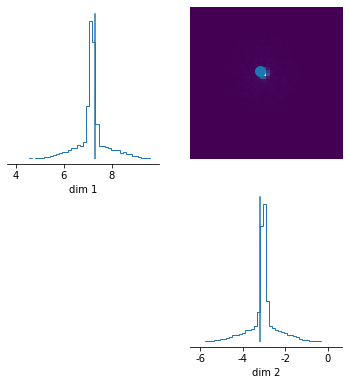

In [138]:
dfgm = df[df["task"] == "gaussian_mixture"]

idx = 0
row = dfgm.iloc[idx]
true_theta=get_true_theta_from_row(row)

print(row["C2ST_Z"])
p = get_relative_path(row["path"], "/home/ben/sci/cnre/benchmarking/multirun/")
print(p)
p = get_posterior_samples(p)
plot_posterior(p, true_theta=true_theta)

r = get_reference_samples_from_row(row)
plot_posterior(r, true_theta=true_theta)

In [139]:
row

task                                                          gaussian_mixture
num_simulations                                                         100000
num_observation                                                              3
seed                                                                 906600540
max_num_epochs                                                             300
algorithm                                                                 CNRE
num_atoms                                                                    2
gamma                                                                      0.1
training_samples_root                                         training-data/02
C2ST                                                                    0.9968
C2ST_Z                                                                 0.99695
MMD                                                                   1.101509
MMD_Z                                               

In [141]:
import torch
task = sbibm.get_task("gaussian_mixture")
num_observation = 3
true_theta = task.get_true_parameters(num_observation)
sbibm_obs = task.get_observation(num_observation)
new_obs = task.get_simulator()(true_theta)
obss = torch.concat([task.get_simulator()(true_theta) for _ in range(100)])
print(true_theta)
print(
    (torch.linalg.norm(sbibm_obs - obss)).mean(),
    (torch.linalg.norm(new_obs - obss)).mean(),
)

tensor([[ 7.3016, -3.2178]])
tensor(10.3346) tensor(13.1742)


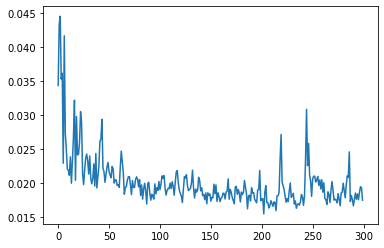

In [20]:
a = get_tensor_from_csv("/home/ben/sci/cnre/benchmarking/multirun/2022-04-02/18-02-23/0/validation_losses.csv.bz2").numconcatplt.plot(a)